In [1]:
import torch
import os
import cv2
import imgaug as ia
import numpy as np
import sys
import json

from imgaug import augmenters as iaa

from collections import defaultdict

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet18 as resnet18
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
!pip install imgaug wandb

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import wandb
wandb.init(project="raai-cv-2021")
None

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: ilya0_0 (use `wandb login --relogin` to force relogin)


In [4]:
IMAGE_EXAMPLE_PATH = '/home/sirius/Рабочий стол/Dataset/01_asphalt(Good)/000000000.png'

In [5]:
image = cv2.imread(IMAGE_EXAMPLE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

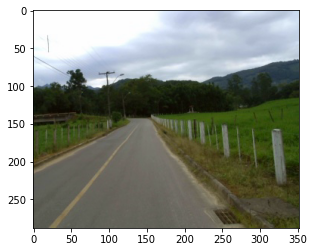

In [6]:
plt.imshow(image)

### Подготовка датасета

In [7]:
DATASET_PATH = '/home/sirius/Рабочий стол/Dataset/'

In [4]:
class DatasetRAM(Dataset):

    def __init__(self, data = None, classes = None, path = None, transform=None):
        super().__init__()
       
        self.transform = transform
        self.class_name_to_idx = {}
        self.path = path
        self.data = []
        self.idx_to_class_name = []
        
        if (data != None):
            self.data = data
            for i in range(classes):
                self.class_name_to_idx[i] = i
                self.idx_to_class_name.append(i)
            return

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)
            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                # считывание с диска и декодирование jpeg данных
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                self.data.append((image, class_name))

    def __getitem__(self, idx):
        image = self.data[idx][0]
        class_name = self.data[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

In [5]:
transform = transforms.Compose([
    iaa.Sequential([
        iaa.Resize({"height": 258, "width": 352})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [10]:
dataset = DatasetRAM(path = DATASET_PATH, transform = transform)

print('Dataset size:', len(dataset))

KeyboardInterrupt: 

In [ ]:
import random

indices = [i for i in range(len(dataset))]
random.shuffle(indices)
train_indices = indices[:int(np.ceil(len(dataset) * 0.8))]
test_indices = indices[int(np.ceil(len(dataset) * 0.8)):]
train_data  = []
test_data = []

for i in range(len(train_indices)):
    img, idx = dataset[train_indices[i]]
    train_data.append((img, idx))
    
for i in range(len(test_indices)):
    img, idx = dataset[test_indices[i]]
    test_data.append((img, idx))
    
train_dataset = DatasetRAM(data = train_data, classes = 7)
test_dataset = DatasetRAM(data = test_data, classes = 7)
print('Train data size:', len(train_dataset))
print('Test data size:', len(test_dataset))

In [ ]:
image, class_idx = train_dataset[0]

print('Image shape:', image.shape)
print('Class idx:', class_idx)
print('Class name:', train_dataset.idx_to_class_name[class_idx])

plt.imshow(image[0], cmap='Greys_r')

In [6]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,  # обучающие данные стоит передавать в случайном порядке
    num_workers=2,  # число потоков подготовки данных. если не удается полностью задействовать GPU, то можно попробовать увеличить, но это увеличит нагрузку на cpu
    pin_memory=True,  # перевод GPU памяти в режим pinned ускоряет загрузку/выгрузку данных
    drop_last=True  # чтобы все батчи были одного размера, лучше сделать True
)

test_dataloader = DataLoader(
    test_dataset,  
    batch_size=8, 
    shuffle=False,
    num_workers=1, 
    pin_memory=True, 
    drop_last=False  # чтобы обработать все тестовые данные
)

NameError: name 'train_dataset' is not defined

In [ ]:
for batch in test_dataloader:
  break

In [ ]:
image_batch, class_idx_batch = batch

print('Image batch size:', image_batch.shape)
print('Class index batch size:', class_idx_batch.shape)

In [ ]:
image_batch

### Подготовка модели

In [9]:
# pip install git+https://github.com/moskomule/homura@v2020.07

In [10]:
import torch.hub
hub_model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    pretrained=True,)

Using cache found in /home/sirius/.cache/torch/hub/moskomule_senet.pytorch_master


In [12]:
hub_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Se

In [13]:
# В целевом датасете 7 классов, поэтому заменим последний слой:
hub_model.fc = nn.Linear(2048, 7)
torch.nn.init.xavier_normal_(hub_model.fc.weight)
hub_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Se

In [ ]:
# Замораживаем все веса модели
for param in hub_model.parameters():
    param.requires_grad = False

# Размораживаем последний линейный слой
for param in hub_model.fc.parameters():
    param.requires_grad = True

In [ ]:
print('Total number of parameters:', sum(param.numel() for param in hub_model.parameters()))

In [ ]:
# 2048 * 7 + 7
print('Number of trainable parameters:', sum(param.numel() for param in hub_model.parameters() if param.requires_grad))

In [14]:
if torch.cuda.is_available():
    hub_model = hub_model.cuda()

In [15]:
optimizer = torch.optim.SGD(hub_model.parameters(), lr=0.001, momentum=0.9)

In [16]:
sd = optimizer.state_dict()
sd['param_groups'][0]['lr'], sd['param_groups'][0]['momentum']

(0.001, 0.9)

In [17]:
def accuracy_wb(dataloader, model, label):
    model = model.eval()
    tp = 0
    with torch.no_grad():
        for batch in dataloader:
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()
            
            logits = model(image_batch)
            classes = torch.argmax(logits, dim=1)
            tp += (class_idx_batch == classes).sum().item()

        acc = tp / len(dataloader.dataset)
        wandb.log({label: acc})
        print(label, acc)

### Обучение

In [32]:
def train(model, num_epochs, prefix):
    for epoch in range(num_epochs):
        print('\nEpoch', epoch)
        model = model.train()

        for batch in train_dataloader:
            # в pytorch градиент хранится в переменной grad и вычисляется при вызове backward
            # при этом он не перезаписывается, а добавляется к старому значению,
            # поэтому необходимо приравнять grad нулю, перед вычислением градиентов
            optimizer.zero_grad()
            
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()

            logits = model(image_batch)

            # вычисляем функцию потерь
            loss = F.cross_entropy(logits, class_idx_batch)

            # вычисляем градиенты
            loss.backward()

            wandb.log({'train_loss': loss})

            # выполняем шаг оптимизации - обновляем веса
            optimizer.step()

        # считаем и логируем метрики качества
        accuracy_wb(train_dataloader, model, 'train_accuracy')
        accuracy_wb(test_dataloader, model, 'test_accuracy')

        # сохраняем промежуточные результаты обучения - веса модели и состояние оптимизатора,
        # чтобы при необходимости возобновить обучение с них
        torch.save(model.state_dict(), prefix + 'model_{}.pth'.format(epoch))
        torch.save(optimizer.state_dict(), prefix + 'optimizer_{}.pth'.format(epoch))

In [ ]:
train(hub_model, 20, 'stage_1_')

In [ ]:
hub_model.load_state_dict(torch.load('stage_1_model_18.pth'))
optimizer.load_state_dict(torch.load('stage_1_optimizer_18.pth'))

In [18]:
# Разморозим последний сверточный слой
for param in hub_model.layer4.parameters():
    param.requires_grad = True

In [ ]:
print('Number of trainable parameters:', sum(param.numel() for param in hub_model.parameters() if param.requires_grad))

In [19]:
sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = 0.0001
optimizer.load_state_dict(sd)

In [ ]:
train(hub_model, 20, 'stage_2_')

In [20]:
hub_model.load_state_dict(torch.load('stage_2_model_14.pth'))
optimizer.load_state_dict(torch.load('stage_2_optimizer_14.pth'))

### Наш датасет

In [21]:
NEW_DATASET_PATH = '/home/sirius/Рабочий стол/our_dataset/'

In [22]:
new_dataset = DatasetRAM(path = NEW_DATASET_PATH, transform = transform)

print('New dataset size:', len(new_dataset))

New dataset size: 4742


In [23]:
import random

indices = [i for i in range(len(new_dataset))]
random.shuffle(indices)
train_indices = indices[:int(np.ceil(len(new_dataset) * 0.8))]
test_indices = indices[int(np.ceil(len(new_dataset) * 0.8)):]
train_data  = []
test_data = []

for i in range(len(train_indices)):
    img, idx = new_dataset[train_indices[i]]
    train_data.append((img, idx))
    
for i in range(len(test_indices)):
    img, idx = new_dataset[test_indices[i]]
    test_data.append((img, idx))
    
new_train_dataset = DatasetRAM(data = train_data, classes = 7)
new_test_dataset = DatasetRAM(data = test_data, classes = 7)
print('Train data size:', len(new_train_dataset))
print('Test data size:', len(new_test_dataset))

Train data size: 3794
Test data size: 948


Image shape: torch.Size([3, 258, 352])
Class idx: 3
Class name: 3


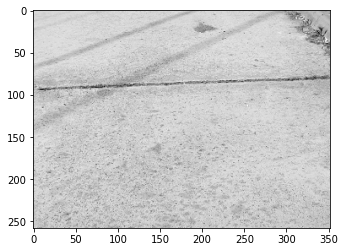

In [24]:
image, class_idx = new_train_dataset[0]

print('Image shape:', image.shape)
print('Class idx:', class_idx)
print('Class name:', new_train_dataset.idx_to_class_name[class_idx])

plt.imshow(image[0], cmap='Greys_r')

In [36]:
train_dataloader = DataLoader(
    new_train_dataset,
    batch_size=8,
    shuffle=True,  # обучающие данные стоит передавать в случайном порядке
    num_workers=2,  # число потоков подготовки данных. если не удается полностью задействовать GPU, то можно попробовать увеличить, но это увеличит нагрузку на cpu
    pin_memory=True,  # перевод GPU памяти в режим pinned ускоряет загрузку/выгрузку данных
    drop_last=True  # чтобы все батчи были одного размера, лучше сделать True
)

test_dataloader = DataLoader(
    new_test_dataset,  
    batch_size=8, 
    shuffle=False,
    num_workers=1, 
    pin_memory=True, 
    drop_last=False  # чтобы обработать все тестовые данные
)

In [37]:
for batch in test_dataloader:
  break

In [38]:
image_batch, class_idx_batch = batch

print('Image batch size:', image_batch.shape)
print('Class index batch size:', class_idx_batch.shape)

Image batch size: torch.Size([8, 3, 258, 352])
Class index batch size: torch.Size([8])


In [39]:
# Замораживаем все веса модели
for param in hub_model.parameters():
    param.requires_grad = False

# Размораживаем последний линейный слой
for param in hub_model.fc.parameters():
    param.requires_grad = True

In [40]:
# 2048 * 7 + 7 = 
print('Number of trainable parameters:', sum(param.numel() for param in hub_model.parameters() if param.requires_grad))

Number of trainable parameters: 14343


In [42]:
# Разморозим последний сверточный слой
for param in hub_model.layer4.parameters():
    param.requires_grad = True

In [43]:
# 2048 * 7 + 7 = 
print('Number of trainable parameters:', sum(param.numel() for param in hub_model.parameters() if param.requires_grad))

Number of trainable parameters: 16551943


In [44]:
train(hub_model, 20, 'stage_3_')


Epoch 0


/home/sirius/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train_accuracy 0.9488666315234581
test_accuracy 0.9145569620253164

Epoch 1
train_accuracy 0.9770690564048498
test_accuracy 0.9514767932489452

Epoch 2
train_accuracy 0.985239852398524
test_accuracy 0.9578059071729957

Epoch 3
train_accuracy 0.9881391671059567
test_accuracy 0.9672995780590717

Epoch 4
train_accuracy 0.989193463363205
test_accuracy 0.9694092827004219

Epoch 5
train_accuracy 0.9894570374275171
test_accuracy 0.9704641350210971

Epoch 6
train_accuracy 0.9902477596204533
test_accuracy 0.9715189873417721

Epoch 7
train_accuracy 0.9902477596204533
test_accuracy 0.9672995780590717

Epoch 8
train_accuracy 0.9899841855561413
test_accuracy 0.9736286919831224

Epoch 9
train_accuracy 0.9897206114918292
test_accuracy 0.9746835443037974

Epoch 10
train_accuracy 0.9905113336847654
test_accuracy 0.9725738396624473

Epoch 11
train_accuracy 0.9907749077490775
test_accuracy 0.9736286919831224

Epoch 12
train_accuracy 0.9905113336847654
test_accuracy 0.9746835443037974

Epoch 13
train_accu

In [45]:
hub_model.load_state_dict(torch.load('stage_3_model_15.pth'))
optimizer.load_state_dict(torch.load('stage_3_optimizer_15.pth'))